# EEG analysis of the Relax Protocol with logistic regression
In this notebook, I am going to analyze EEG signals collected during evening reading sessions for days where I perfomed the Relax Protocol right before the session (relax_protocol_alpha_cleaned.csv) and on days where no protocol was performed (no_protocol_alpha_cleaned.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its  Research Kit.

In this notebook I will cover:
- Use ordinary logistic regression to identify if there are differences between the EEG datasets

In 3 separate notebooks I will cover:

- Signal processing and artifact rejection
- Extracting power in the alpha band (the feature of choice)
- Use a convolutional neural network to identify if there are differences between the EEG datasets



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression


In [4]:
relax_protocol_alpha = pd.read_csv('data/relax_protocol/features/relax_protocol_alpha_cleaned.csv')
no_protocol_alpha = pd.read_csv('data/relax_protocol/features/no_protocol_alpha_cleaned.csv')

In [5]:
eeg_columns = relax_protocol_alpha.columns

In [7]:
relax_protocol_alpha["has_focus_protocol"] = 1
no_protocol_alpha["has_focus_protocol"] = 0
data = pd.concat([relax_protocol_alpha, no_protocol_alpha], ignore_index=True)


In [8]:
data

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,has_focus_protocol
0,3.852366,1.351839,17.864556,1.354578,1.101281,2.241158,3.873075,3.848341,11.808572,6.970382,3.533553,1
1,5.688932,0.910222,19.097158,2.086638,0.997090,1.975207,6.750688,9.369459,6.607489,5.195529,6.279198,1
2,10.342225,3.775390,20.645936,3.457180,35.158715,6.170227,4.754038,6.105202,11.472558,19.150829,10.685146,1
3,21.848683,3.522477,67.380364,19.146327,5.076937,24.908732,4.224065,14.907476,56.992119,34.697014,13.103675,1
4,8.302813,3.173987,16.858043,4.920124,4.189323,7.773439,7.718138,6.635649,6.391343,5.174117,7.412140,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,0.877941,1.275343,33.478285,0.635542,1.803572,0.997318,8.548996,6.985823,9.944197,9.759315,9.877679,0
1532,0.542360,1.095387,62.673717,1.357057,3.240550,0.212099,6.069939,6.958318,6.837605,18.062459,7.169066,0
1533,0.347890,0.233154,45.300936,0.530864,3.845705,0.491123,5.503666,3.898973,6.860019,15.550546,8.114855,0
1534,1.222517,1.134030,59.451119,1.273111,4.202553,0.803027,6.989572,6.356289,11.424595,72.387919,6.270086,0


In [9]:
X = data[eeg_columns].values
y = data['has_focus_protocol'].values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Text(0.5, 1.0, 'Scaled alpha for EEG after protocol (first half) and without protocol (second half)')

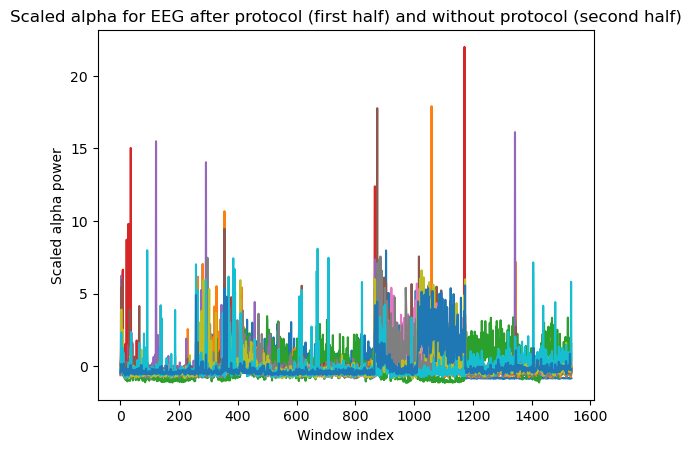

In [11]:
plt.plot(X_scaled)
plt.ylabel("Scaled alpha power")
plt.xlabel("Window index")
plt.title("Scaled alpha for EEG after protocol (first half) and without protocol (second half)")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
model = LogisticRegression()

In [14]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [15]:
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {int(accuracy*100)}%")

Test Accuracy: 87%


In [16]:
model.coef_

array([[ 1.25248183,  0.98208984, -0.83138495,  0.44758332, -0.10003237,
        -0.81200843, -1.5697082 , -0.08429935,  0.71372301,  0.13232439,
        -3.74053326]])

In [17]:
print("EEG channel  coefficient")
for i in range(len(eeg_columns)):
    print(f"{eeg_columns[i]}\t{np.round(model.coef_[0][i], 2)}")

EEG channel  coefficient
Ch1RawEEG	1.25
Ch2RawEEG	0.98
Ch3RawEEG	-0.83
Ch4RawEEG	0.45
Ch5RawEEG	-0.1
Ch6RawEEG	-0.81
Ch7RawEEG	-1.57
Ch8RawEEG	-0.08
Ch10RawEEG	0.71
Ch11RawEEG	0.13
Ch12RawEEG	-3.74


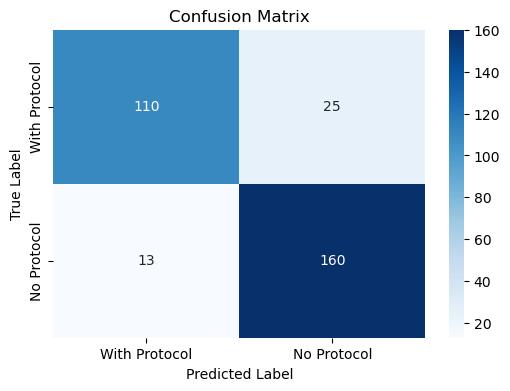

In [18]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['With Protocol', 'No Protocol'], yticklabels=['With Protocol', 'No Protocol'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This simple logistic regression classifier performs at over 85% accuracy. It seems most of the prediction is coming from increases in alpha power in channels 1 and 2. 

Compared to convolutional neural network, this linear model is 10% less accurate, still way more reliable than chance for quick and easy applications